<a href="https://colab.research.google.com/github/mancap314/miscellanous/blob/master/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Stock price

This is a notebook illustrating how to predict stock price from [Yahoo Finance](https://finance.yahoo.com/) data with a recurrent neural network.

In [1]:
# Install library for fetching Yahoo Finance data
!pip install yfinance

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
from typing import Tuple, Union
from numpy import array, arange, zeros
from numpy.random import permutation
from pathlib import Path
from datetime import datetime, timedelta

plt.rcParams['figure.figsize'] = [12, 9]  # plot larger than default

Define some constants (adapt the values to your use case):

In [3]:
stock = 'AAPL'
# Train model with daily data between `start` and `end`
start = '2017-01-01'
end = '2020-12-31'
target = 'Close'
# We will use the `n_prior` previous days to predict the nex `n_to_predict` days
n_prior = 21
n_to_predict = 14
# Proportion of validation and test data
p_val = .1
p_test = .2 

## Fetching data
Fetch data directly from the *yfinance* library

In [4]:
data = yf.download(tickers=stock, period='1d', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [5]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.413372,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.382690,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.521944,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.828764,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,28.083660,134247600
...,...,...,...,...,...,...
2020-12-23,132.160004,132.429993,130.779999,130.960007,130.542862,88223700
2020-12-24,131.320007,133.460007,131.100006,131.970001,131.549637,54930100
2020-12-28,133.990005,137.339996,133.509995,136.690002,136.254608,124486200


We want only the `target` values:

In [6]:
data = data[[target]]

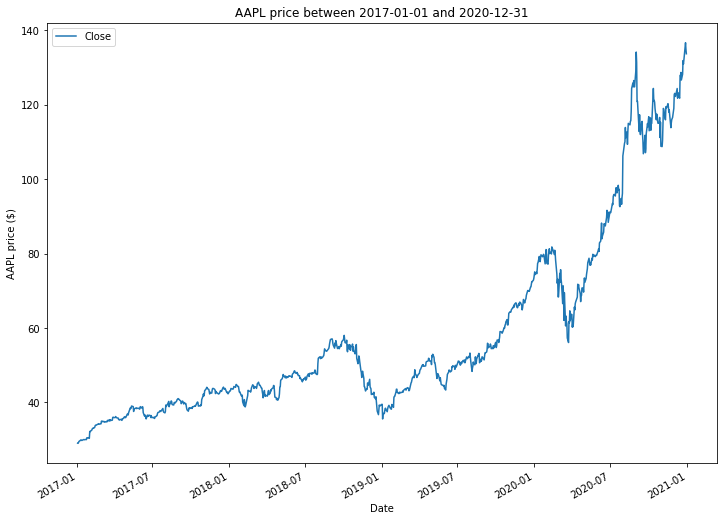

In [7]:
data.plot()
plt.xlabel(f'Date')
plt.ylabel(f'{stock} price ($)')
plt.title(f'{stock} price between {start} and {end}')
plt.show()

## Prepare training data
First we define a function `build_x_y()` that will take slices from the column `target` of `data`. Each slice will be split into a range of `n_prior` days for `X` and the following `n_to_predict` day for `y`.

### Create `X` and `y`

In [8]:
def build_x_y(data: DataFrame, target: str = 'Close',  n_prior: int = 21, 
              n_to_predict: int = 14) -> Tuple[array, array]:
    """ Split `df` into X and y. X is a 2-dimensional numpy array. The first 
    dimension corresponds to the sample, the second to the sequence in a sample 
    and the third to the features in each element of the sequence. `y` is a 
    2-dimensional array, the first is for the samples and the second for the 
    output values of the corresponding sequence.

    Args:
        data (DataFrame): Preprocessed input dataset
        target (str, optional): Column name of the target variable in `data`. 
            Defaults to 'Close'.
        n_prior (int, optional): Number of days in the past used in each sample
           of the training dataset. Defaults to 21.
        n_to_predict (int, optional): Numbers of day to predict ahead. 
            Defaults to 14.

    Returns:
        Tuple[array, array]: Input and output corresponding to the preprocessed 
          samples in `data`.
    """
    n = n_prior + n_to_predict  # batch "width"
    s0, s1 = data.shape[0], data.shape[1]
    s = s0 - n  # size of training data

    X, y = zeros(shape=(s, n_prior, s1)), zeros(shape=(s, n_to_predict))
    shuffled_order = permutation(arange(0, s, 1)) # shuffle data directly
    for i in shuffled_order:
        X[i] = data.iloc[i: i + n_prior,:].values
        y[i] = data[target][i + n_prior: i + n]
        # Normalize each batch individually
        mean, std = X[i].mean(), X[i].std()
        X[i] = (X[i] - mean) / std
        y[i] = (y[i] - mean) / std
        
    return X, y

In [9]:
X, y = build_x_y(data=data, target='Close', n_prior=n_prior, n_to_predict=n_to_predict)

### Split `X` and `y`
Compute where to split `X` and `y` to obtain a proportion `p_val` of validation data and `p_test` of test data:

In [10]:
def get_split_inds(size: int, p_val: float = .1, p_test: float = .2, 
                   do_shuffle: bool = False) -> Tuple[array, array, array]:
    """ Compute indices corresponding to the random splitting of `size` samples in train, validation and test sets 
    with size corresponding to `p_test` and `p_val`.

    Args:
        size (int): Number of samples in the dataset to split.
        p_val (float, optional): Proportion of validation data in the split. Defaults to .1.
        p_test (float, optional): Proportion of test data in the split. Defaults to .2.

    Returns:
        Tuple[array, array, array]: Three arrays corresponding to the indices of the train, validation and test sets.
    """
    indices = arange(0, size, 1)
    if do_shuffle:
      indices = permutation(indices)

    val_split_ind = round(size * (1 - p_test - p_val))
    test_split_ind = round(size * (1 - p_test))

    train_inds = indices[:val_split_ind]
    val_inds = indices[val_split_ind: test_split_ind]
    test_inds = indices[test_split_ind:]
    
    return train_inds, val_inds, test_inds

In [11]:
size = X.shape[0]
train_inds, val_inds, test_inds = get_split_inds(size=size, p_val=p_val, p_test=p_test)
X_train, X_val, X_test = X[train_inds], X[val_inds], X[test_inds]
y_train, y_val, y_test = y[train_inds], y[val_inds], y[test_inds]

## Modelization



In [12]:
from tensorflow.keras.layers import Input, GRU, Lambda, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, History
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow import expand_dims, matmul
from tensorflow.nn import softmax

Define some model trainin specific constants:

In [13]:
n_units = 100  # size of the LSTM layers
lr = 1e-3  # learning rate
dr = .99  # decay rate
max_epochs = 300
patience = 10
batch_size = 32
model_path = None  # if None: will not be persisted
patience = 10


Define a function to provide a deep recurrent model:

In [14]:
def attention_seq(query_value, scale):
    """ Define time series specific attention layer
    see: https://stackoverflow.com/questions/61757475/sequence-to-sequence-for-time-series-prediction """
    query, value = query_value
    score = matmul(query, value, transpose_b=True) # (batch, timestamp, 1)
    score = scale * score # scale with a fixed number (it can be finetuned or learned during train)
    score = softmax(score, axis=1) # softmax on timestamp axis
    score = score * query # (batch, timestamp, feat)
    return score


def get_model(n_prior: int, n_features: int, n_to_predict: int, 
              n_units: int = 100) -> Model:
    """ Build and return a recurrent auto-encoder model for predicting.

    Args:
        n_prior (int): number of days in the past used in each sample of the training dataset.
        n_features (int): number of  (columns) in the input dataset.
        n_to_predict (int): numbers of day to predict ahead
        n_units (int): size of the recurrent layer

    Returns:
        tf.keras.models.Model: reccurent auto-encoder model for predicting
    """
    inp = Input((n_prior, n_features))
    seq, state = GRU(n_units, activation='relu',
                    return_state=True, return_sequences=True)(inp)
    att = Lambda(attention_seq, arguments={'scale': 0.05})([seq, expand_dims(state,1)])
    x = GRU(n_units, activation='relu')(att)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(n_to_predict)(x)

    model = Model(inp, out)
    return model

Define a function for training the model:

In [15]:
def train_persist_model(model: Model, X_train: DataFrame, X_val: DataFrame, X_test: DataFrame, y_train: Series,
                        y_val: Series, y_test: Series, model_name: str, model_path: Union[str, Path, None], lr: float = 1e-3, dr: float = .99, 
                        max_epochs: int = 300, patience: int = 10, batch_size: int = 32, plot: bool = True, verbose: int = 0) -> None:
    """ Train and persist a model for predicting.

    Args:
        model (tf.keras.models.Model): Tensorflow Keras model to train and persist
        X_train (DataFrame): Training input dataset corresponding to past data with their features
        X_val (DataFrame): Validation input dataset. Used at each batch to monitor model performance.
        X_test (DataFrame): Test input dataset, for measuring model performance after training.
        y_train (Series): Training output ground truth
        y_val (Series): Validation output ground truth
        y_test (Series): Test output ground truth.
        model_name (str): name of the model
        model_path (Union[str, Path]): Path under which the model will be persisted. If None, the model will not be persisted.
        lr (float, optional): Learning rate for the optimizer training the model. Defaults to 1e-3.
        dr (float, optional): Decay rate for the learning rate. Defaults to .99.
        max_epochs (int, optional): Max. number of epochs for training the model. Defaults to 300.
        patience (int, optional): number of epochs without improvement of val_loss before stopping
        batch_size (int, optional): Number of training data samples in each batch. Defaults to 32.
        plot (bool, optional): If to generate and persist plot corresponding to the training history. Defaults to True.
        verbose (int, optional): If to print details during the training. Defaults to 0.
    """
    reduce_lr = LearningRateScheduler(lambda x: lr * dr ** x)
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min',
                                   restore_best_weights=True)


    model.compile(optimizer=Adam(),
                loss=Huber(),
                metrics=[MeanAbsoluteError()])

    history = model.fit(X_train, y_train, 
                        epochs=max_epochs, 
                        validation_data=(X_val, y_val),
                        batch_size=batch_size,
                        verbose=verbose,
                        callbacks=[reduce_lr, early_stopping])

    if plot:
        plot_training(history=history, model_name=model_name)
    
    if model_path:
      model.save(model_path)
      print(f'INFO: model {model_path} saved under {model_path}')

    results = model.evaluate(X_test, y_test)
    test_loss, test_mae = results[0], results[1]
    print(f'INFO: model evaluation on test data:\n\tloss: {test_loss}\n\tMAE: {test_mae}')

And finally, define a function to plot the model training:

In [16]:
def plot_training(history: History, model_name: str) -> None:
    """ Plot history of model training. The model must contain MAE as a metric.
        Saves the plot in the folder `plots_dir` defined in *parameters.py* under the name `model_name`.jpg
    Args:
        history (tf.keras.callbacks.History): model history resulting from `.fit()`
        model_name (str): [description]
    """
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle(f'{model_name} training')
    
    ax1.plot(history.history['mean_absolute_error'])
    ax1.plot(history.history['val_mean_absolute_error'])
    ax1.set_title(f'{model_name} mean_absolute_error')
    ax1.set(xlabel='epoch', ylabel='mean_absolute_error')
    ax1.legend(['train', 'val'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title(f'{model_name} loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train', 'val'], loc='upper left')
    
    plt.show()

Now combine all this to train the model:

In [17]:
model = get_model(n_prior=n_prior, n_features=1, n_to_predict=n_to_predict, n_units=n_units)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 21, 1)]      0                                            
__________________________________________________________________________________________________
gru (GRU)                       [(None, 21, 100), (N 30900       input_1[0][0]                    
__________________________________________________________________________________________________
tf.expand_dims (TFOpLambda)     (None, 1, 100)       0           gru[0][1]                        
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 21, 100)      0           gru[0][0]                        
                                                                 tf.expand_dims[0][0]         

Epoch 1/300
22/22 [==============================] - 4s 56ms/step - loss: 1.6631 - mean_absolute_error: 2.1223 - val_loss: 2.3871 - val_mean_absolute_error: 2.8727
Epoch 2/300
22/22 [==============================] - 1s 36ms/step - loss: 1.5287 - mean_absolute_error: 1.9735 - val_loss: 2.0281 - val_mean_absolute_error: 2.4896
Epoch 3/300
22/22 [==============================] - 1s 37ms/step - loss: 1.4215 - mean_absolute_error: 1.8515 - val_loss: 1.6598 - val_mean_absolute_error: 2.0737
Epoch 4/300
22/22 [==============================] - 1s 36ms/step - loss: 1.3099 - mean_absolute_error: 1.7271 - val_loss: 1.4946 - val_mean_absolute_error: 1.8931
Epoch 5/300
22/22 [==============================] - 1s 36ms/step - loss: 1.2358 - mean_absolute_error: 1.6489 - val_loss: 1.4121 - val_mean_absolute_error: 1.8006
Epoch 6/300
22/22 [==============================] - 1s 36ms/step - loss: 1.1944 - mean_absolute_error: 1.6064 - val_loss: 1.5767 - val_mean_absolute_error: 1.9942
Epoch 7/300
22/2

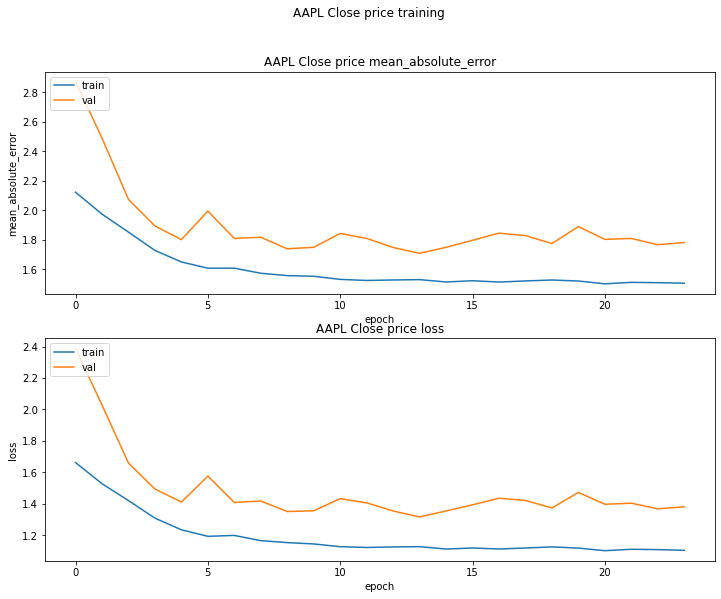

7/7 [==============================] - 0s 9ms/step - loss: 0.7421 - mean_absolute_error: 1.1229
INFO: model evaluation on test data:
	loss: 0.7421121597290039
	MAE: 1.1229300498962402


In [18]:
train_persist_model(model=model, X_train=X_train, X_val=X_val, X_test=X_test, 
                    y_train=y_train, y_val=y_val, y_test=y_test, 
                    model_name=f'{stock} {target} price', model_path=model_path, lr=lr, dr=dr,
                    max_epochs=max_epochs, patience=patience, 
                    batch_size=batch_size, plot=True, verbose=1)

## Make prediction

In [19]:
def generate_prediction(predict_from: str, stock: str, target: str, model: Model, 
                        n_prior: int = 21, valid: bool = False) -> None:
  """ Generate predictions from the date `predict_from` based on the `n_prior` 
  previous values for the price `target` of `stock`
    Args:
        predict_from (str): format 'yyyy-mm-dd', date after which the predictions will start
        stock (str): code of the stock on Yahoo Finance
        target (str): target price to predict (e.g. 'Close')
        model (Model): Tensorflow model trained for making predictions
        n_prior (int): number of previous values to use for the prediction 
            (must be the same than the one used to train the `model`)
        valid (bool): if to plot the actual vs. the predicted values 
            (only if the prediction time range lies in the past)
    """
  predict_from_dt = datetime.strptime(predict_from, '%Y-%m-%d')
  start_dt = predict_from_dt - timedelta(days=n_prior + 10)
  start = start_dt.strftime('%Y-%m-%d')
  data = yf.download(tickers=stock, period='1d', start=start, end=predict_from)
  data = data[target]
  # Normalize
  mean, std = data.mean(), data.std()
  data = (data - mean) / std
  data = data.values[data.shape[0] - n_prior:].reshape(1, -1, 1)

  predictions = model.predict(data)
  predictions = predictions * std + mean # de-normalize
  predictions = predictions.flatten()
  prediction_dates = [predict_from_dt + timedelta(days=i+1) for i in range(predictions.shape[0])]
  predictions = DataFrame({'date': prediction_dates, 'prediction': predictions})
  predictions = predictions.set_index('date')
  if valid:
    start_valid = predict_from_dt + timedelta(days=1)
    end_valid = predict_from_dt + timedelta(predictions.shape[0] + 10)
    start_valid = start_valid.strftime('%Y-%m-%d')
    end_valid = end_valid.strftime('%Y-%m-%d')
    true_values = yf.download(tickers=stock, period='1d', start=start_valid, end=end_valid)
    true_values = true_values[[target]].loc[:predictions.index.max(),:]
    fig, ax = plt.subplots(1)
    ax.plot(true_values, label='actual')
    ax.plot(predictions, label='predicted')
    ax.set_title(f'Actual vs. Prediction for stock {stock} between {start_valid} and {end_valid}')
    ax.set(xlabel='day', ylabel=f'{stock} ${target} price ($)')
    ax.legend()
    plt.show()
  return predictions

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


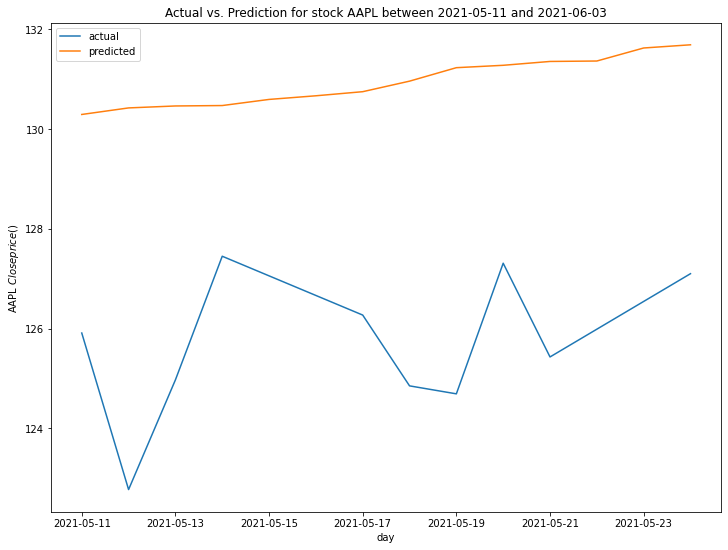

In [21]:
predict_from = '2021-05-10'
predictions = generate_prediction(predict_from=predict_from, stock=stock, 
                                  target=target, model=model, n_prior=n_prior, 
                                  valid=True)

In [ ]:
predictions